---
title: "Lab 7"
format:
  html:
    embed-resources: true
    code-fold: true
execute:
  echo: true
  warning: false
  message: false
---

In [1]:
import pandas as pd
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [2]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [3]:
ha.isnull().sum()

,0
age,0
sex,0
cp,0
trtbps,0
chol,0
restecg,0
thalach,0
output,0


In [4]:
ha.describe()

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


Looks like We are all good! I am probably going to make dummy's as well to make it simplier, but I can do it later in the pipelines

# **Part One: Fitting Models**

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

Find the best model based on ROC AUC for predicting the target variable.

Report the (cross-validated!) ROC AUC metric.

Fit the final model.

Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

(Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

Below is the stuff I will be using for all of them :

I was writing this out for each then realized I could just use it at the start and come back to this

In [11]:
X = ha.drop('output', axis=1)
y = ha['output']

print(" X variables :")
print(X.head())
print("\n Y varbles :  ")
print(y.head())

 X variables :
   age  sex  cp  trtbps  chol  restecg  thalach
0   63    1   3     145   233        0      150
1   37    1   2     130   250        1      187
2   56    1   1     120   236        1      178
3   57    0   0     120   354        1      163
4   57    1   0     140   192        1      148

 Y varbles :  
0    1
1    1
2    1
3    1
4    1
Name: output, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (204, 7)
X_test shape: (69, 7)
y_train shape: (204,)
y_test shape: (69,)


I had got used to doing this but realized they already put the cat variables into dummy's so I treated them as numeric. It wasn't the simplest way, but I was aware of this for the interpretations and was still able to make it work

In [13]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['age', 'sex', 'cp', 'trtbps', 'chol', 'restecg', 'thalach']
Categorical features: []


In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessing pipeline created:")
print(preprocessor)

Preprocessing pipeline created:
ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['age', 'sex', 'cp', 'trtbps', 'chol',
                                  'restecg', 'thalach']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])])


**Question 1 : KNN**

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])


print(knn_pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'sex', 'cp', 'trtbps',
                                                   'chol', 'restecg',
                                                   'thalach']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', KNeighborsClassifier())])


Hyper Tune :

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_neighbors': range(1, 31),
    'classifier__weights': ['uniform', 'distance'], # Searched it up and seemed like it was best to include weights and metrics also
    'classifier__metric': ['euclidean', 'manhattan']
}

# As you said I used the helpful function does that does roc auc for you
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best cross-validated ROC AUC:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)


Best cross-validated ROC AUC: 0.8548758259284576
Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 27, 'classifier__weights': 'uniform'}


I tested multiple KKN pipelines, varying the number of neighbors, the weights, and metrics. The grid search used 5-fold cross-validation and ROC AUC as the performance metric. After testing 120 model combinations (30 * 2 * 2), the best-performing configuration was manhattan, 27 k, and unfirom!

ALso to note we got a good cross-validated ROC AUC score here of 0.85487!

Test Set ROC AUC: 0.8416


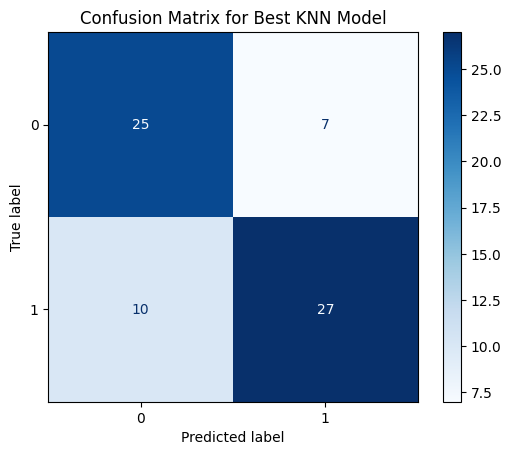

In [17]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_knn_model = grid_search.best_estimator_

# Predict probabilities for ROC AUC
y_pred_proba = best_knn_model.predict_proba(X_test)[:, 1]

# Predict classes for confusion matrix
y_pred = best_knn_model.predict(X_test)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test Set ROC AUC: {roc_auc:.4f}")

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best KNN Model")
plt.show()


So it looks like the Best cross-validated ROC AUC is  0.8548758259284576  but after testing it on the test set the Roc Auc I got is 0.8416! This still seems like a very good score though!

Additionaly  the conusion matrix for thi smodel was pretty successfully, correctly guesting 52 out of 69 times! Not perfect, but pretty good

**Question 2 : Logistic Regression**

In [18]:
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

print(logreg_pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'sex', 'cp', 'trtbps',
                                                   'chol', 'restecg',
                                                   'thalach']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', LogisticRegression())])


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid_logreg = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs'] # seems these are the two other major options for this
}

grid_search_logreg = GridSearchCV(logreg_pipeline, param_grid_logreg, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

print("Best cross-validated ROC AUC for Logistic Regression:", grid_search_logreg.best_score_)
print("Best parameters for Logistic Regression:", grid_search_logreg.best_params_)

Best cross-validated ROC AUC for Logistic Regression: 0.8492822966507176
Best parameters for Logistic Regression: {'classifier__C': 100, 'classifier__solver': 'lbfgs'}


I tested multiple logistic regression pipelines, varying both the regulizar strength C and the solver (liblinear and lbfgs). The grid search used 5-fold cross-validation and ROC AUC as the performance metric. After testing 12 model combinations, the best-performing configuration was C = 100 with the lbfgs solver



Also our corss validated ROC AUC is pretty good again at 0.8492

Test Set ROC AUC for Logistic Regression: 0.8657


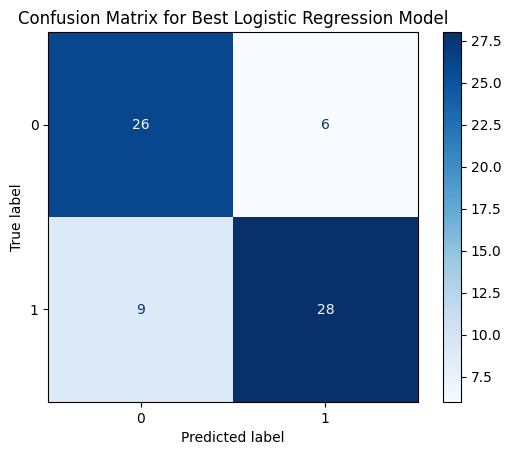

In [20]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# for getting the best model
best_logreg_model = grid_search_logreg.best_estimator_

# Predict probabilities and classes
y_pred_proba_logreg = best_logreg_model.predict_proba(X_test)[:, 1]
y_pred_logreg = best_logreg_model.predict(X_test)

# Calculate Test Set ROC AUC
roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)
print(f"Test Set ROC AUC for Logistic Regression: {roc_auc_logreg:.4f}")

# Generate Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=best_logreg_model.classes_)
disp_logreg.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Logistic Regression Model")
plt.show()

We actually have an amazing test ROC AUC for this logistic regression at 0.8657

Also we predicted 54 our of 69 cases correct, which seems to be a pretty accruate model given the data we got

In the case of a logistic regression model, we also want to look at the coefficients

This is a part where I used some AI help as I often stronggle correctly pulling coefficient values from model like this, but I do beliveve I understand the process that is going on here

In [21]:
best_logreg_classifier = best_logreg_model.named_steps['classifier']

# Get feature names after preprocessing (scaling and one-hot encoding if any)
preprocessor_transformed_features = []

# Numerical features
for feature in numerical_features:
    preprocessor_transformed_features.append(feature)

# No cat variables so good here


coefficients = best_logreg_classifier.coef_[0]
feature_importance = pd.DataFrame({'Feature': preprocessor_transformed_features, 'Coefficient': coefficients})


print("Logistic Regression Model Coefficients:")
print(feature_importance)


Logistic Regression Model Coefficients:
   Feature  Coefficient
0      age    -0.294154
1      sex    -0.954134
2       cp     0.965709
3   trtbps    -0.286061
4     chol    -0.271049
5  restecg     0.166794
6  thalach     0.901074


These coefficients are in a weird form given they are part of logistic regression models, but their signs still tells us some helpful information

* As age increases, the liklihood of a heart attack slightly decreases in the model (holding other variables constant) -- this seems ver counterintuitve, but age could be positively associated with a lot of other variabkes of risk in this dataset throwing it off
* Assuming Males = 1 (as is often the case), males often have lower predicted odds of heat attack compared to demtailes.
* Higher chest pain type values increase the odds of being diagnostic at risk of a heart attacj
* Higher resting blood pressure is associated with a slightly lower risk, holding other features constant
* Higher cholustestrol slightly decreases the prdicted risk in this model (this also defintely seems counter intuitive)
* Higher levels of resting electrocardiographic results are associated wiht a higher risk of heart attack
* Finally, maximum heartrate reaching during exercise is positively associated with higher risk of heart attack diagnosis


In [22]:

import numpy as np
odds_ratios = np.exp([ -0.294154, -0.954134, 0.965709, -0.286061, -0.271049, 0.166794, 0.901074 ])
print(odds_ratios)


[0.74516173 0.38514554 2.62664929 0.75121679 0.76257913 1.18151085
 2.46224614]


We could also convert them to odds for easier interpretation

So for example, that first coefficient would say that males have approximately 26% lower odds compared to females

Or cp (the third coefficient) is saying that each one level up in cp is associated with the odds of heart attack risk increasing by 162% -- this seems pretty extreme but the data we got in our sample maybe just happeend to align with this

**Question 3 : Decision Tree**

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

print(dt_pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'sex', 'cp', 'trtbps',
                                                   'chol', 'restecg',
                                                   'thalach']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid_dt = {
    'classifier__max_depth':  [3, 5, 7, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(dt_pipeline, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print("Best cross-validated ROC AUC for Decision Tree:", grid_search_dt.best_score_)
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)

Best cross-validated ROC AUC for Decision Tree: 0.7858965595807701
Best parameters for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


I tested multipledecision tree pipelines, varying both the dpeth,split, and leaf. The grid search used 5-fold cross-validation and ROC AUC as the performance metric. After testing 45 model combinations, the best-performing configuration wasmax depth of 3, min sample leafs of 1, and min samples split of 2

The result was a ROC AUC of 0.7860

Test Set ROC AUC for Decision Tree: 0.7601


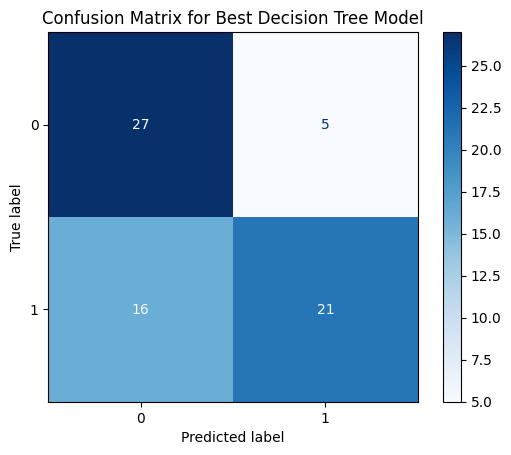

In [25]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_dt_model = grid_search_dt.best_estimator_

# Predict probabilities for ROC AUC on the test set
y_pred_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]

# Predict classes for confusion matrix on the test set
y_pred_dt = best_dt_model.predict(X_test)

# Calculate Test Set ROC AUC
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print(f"Test Set ROC AUC for Decision Tree: {roc_auc_dt:.4f}")

# Generate Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=best_dt_model.classes_)
disp_dt.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Decision Tree Model")
plt.show()

Once again doing a pretty good job. WE got a ROC AUC of 0.7601 , so slightly lower than some of the other models, but a good job nonetheless predicting 48 out of 69 which seems pretty good

Now again its time to look at some of those coefficients

In [26]:
best_dt_classifier = best_dt_model.named_steps['classifier']

feature_importances = best_dt_classifier.feature_importances_

# Get feature names after preprocessing
transformed_features = []


for feature in numerical_features:
    transferred_features = transformed_features.append(feature)

feature_importance_df = pd.DataFrame({'Feature': numerical_features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Decision Tree Model Feature Importances:")
print(feature_importance_df)

Decision Tree Model Feature Importances:
   Feature  Importance
2       cp    0.623278
0      age    0.126198
6  thalach    0.088147
1      sex    0.082129
4     chol    0.045895
3   trtbps    0.034354
5  restecg    0.000000


At first I thought these results were super intresting and odd with them all being positive, but upon searching it up this is normal and in a decision tree the feature importance doesn't measure direction, but how much that feature helps prediciton

So with this in mind, cp have the bigest impact with restecg having the least

It should be noted for a variable like cp that higgh importance level shouldn't be interpreted as higher cp valyes always increase the risks, but rather that it was the most useful variavble overall for dividing patients into high and low groups

**Question 4 : Interpretation**

Which predictors were most important to predicting heart attack risk?

Based on the coefficients that we identified in The logisitc Regression and Decision Tree Model (not KNN as coefficients arn't pulled in the same way) we see that the most important variable in all situations was cp with then some differences between the models in the fallowing variables.

The decision Tree model identified chest pain (cp) as the most dominate feature, accountng for appx 62% of the models total importance. The next most infleunctial was age at 0.12, thalach at 0.09, and blood pressure at 0.08. sex, chol, and trtbps all fallowed it cloely behind. It is intresting to note that restecg had zero importance in the tree, but this does not mean in the real world this variable don't have an impact, this is likely just do to them not being used for any splits in the model

Logistical Regression also empahsized cp, sex, and thalach as the largest coefficient predictors (both being positve predictors of heart attack) while age, resting blood presure, and cholostrol all showed small neagitve coefficients, showing smaller impacts.

**Q5: ROC Curve**

Plot the ROC Curve for your three models above.

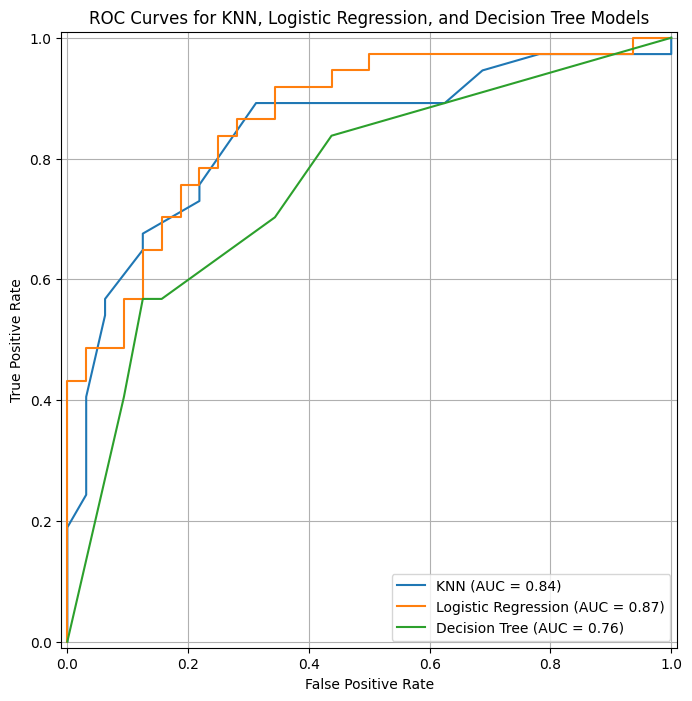

In [27]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
ax = plt.gca()

# Plotting each model with same step, just changing to correct name
RocCurveDisplay.from_estimator(best_knn_model, X_test, y_test, name='KNN', ax=ax)
RocCurveDisplay.from_estimator(best_logreg_model, X_test, y_test, name='Logistic Regression', ax=ax)
RocCurveDisplay.from_estimator(best_dt_model, X_test, y_test, name='Decision Tree', ax=ax)

plt.title('ROC Curves for KNN, Logistic Regression, and Decision Tree Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# **Part Two: Metrics**

Consider the following metrics:

* True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

* Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

* True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One

In [29]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, precision_score, make_scorer
import numpy as np
import pandas as pd

# Define custom scorer for True Negative Rate (Specificity)
# Assuming 1 is the positive class, 0 is the negative class for y
specificity_scorer = make_scorer(recall_score, pos_label=0)

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'specificity': specificity_scorer,
    'roc_auc': 'roc_auc' # Including ROC AUC for completeness as it was a key tuning metric
}

models = {
    'KNN': best_knn_model,
    'Logistic Regression': best_logreg_model,
    'Decision Tree': best_dt_model
}

results_data = []

print("Calculating cross-validated metrics for each model...")
for name, model in models.items():
    cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, n_jobs=-1)

    model_metrics = {
        'Model': name,
        'Mean Recall (Sensitivity)': np.mean(cv_results['test_recall']),
        'Mean Precision (Positive Predictive Value)': np.mean(cv_results['test_precision']),
        'Mean Specificity (True Negative Rate)': np.mean(cv_results['test_specificity']),
        'Mean ROC AUC': np.mean(cv_results['test_roc_auc'])
    }
    results_data.append(model_metrics)

    print(f"\n--- {name} ---")
    print(f"Mean Recall (Sensitivity): {model_metrics['Mean Recall (Sensitivity)']:.4f}")
    print(f"Mean Precision (Positive Predictive Value): {model_metrics['Mean Precision (Positive Predictive Value)']:.4f}")
    print(f"Mean Specificity (True Negative Rate): {model_metrics['Mean Specificity (True Negative Rate)']:.4f}")
    print(f"Mean ROC AUC: {model_metrics['Mean ROC AUC']:.4f}")

# Display results in a DataFrame for better readability
results_df = pd.DataFrame(results_data)
results_df = results_df.set_index('Model')

print("\nCross-validated Metrics Summary:")
print(results_df.round(4))


Calculating cross-validated metrics for each model...

--- KNN ---
Mean Recall (Sensitivity): 0.7943
Mean Precision (Positive Predictive Value): 0.7976
Mean Specificity (True Negative Rate): 0.7628
Mean ROC AUC: 0.8460

--- Logistic Regression ---
Mean Recall (Sensitivity): 0.8152
Mean Precision (Positive Predictive Value): 0.7868
Mean Specificity (True Negative Rate): 0.7391
Mean ROC AUC: 0.8530

--- Decision Tree ---
Mean Recall (Sensitivity): 0.7398
Mean Precision (Positive Predictive Value): 0.7958
Mean Specificity (True Negative Rate): 0.7788
Mean ROC AUC: 0.7732

Cross-validated Metrics Summary:
                     Mean Recall (Sensitivity)  \
Model                                            
KNN                                     0.7943   
Logistic Regression                     0.8152   
Decision Tree                           0.7398   

                     Mean Precision (Positive Predictive Value)  \
Model                                                             
KNN   

Quick note here, I ran all of this indivudally, but used some ai to format into the nicely to read output about as mine was super clucky before, but it is comprised of the exact same content


# **Part Three: Discussion**

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

*Which metric(s) you would use for model selection and why.*

*Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.*

*What score you should expect for your chosen metric(s) using your chosen model to predict future observations.*

* Q1
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

* Q2
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

* Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

* Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

**Q1**

If the hospital faces a severe lawsuit if they deem a patetient to be low risk, and they later experience a heart attack, this would be preidcting 0 and the true value is 1

The metric we would thus want to use here is RECALL (SENSATIVITY) since this is measuring the prortion of actual heart-attack risk patients that are correctly identified

The model that I would thus suggest woud be Logisitic regression as it had the highest recall value of 0.8152 (and also best avg. ROC AUC of 0.853) making it the saftest choice when missung a TRUE at risk patenint is costly

You can expect around 81% sensativity meaning it will correctly identify someone who should be flagged for a heart attack as flagged around 8/10 times. This is okay but if this is a massive concern based on our data and models only 80% of the time could cause major issues still

**Q2**

If the hospital is overful and only wants to use space for the patneits most in need, we want to eliminate the flase positives meaning they got flagged and are taking up a bed, but shouldn't of been flagged.

For this the most important metric to look at is Precision meaning of all the positive cases, the people in the beds, how many really need to be there (of course you would't want to not give beds to missed diagnosed high risk, but in the context of the scenario precision seems to make more sense)

The best model for this would actually be the decision tree then with the slightly highest Decision Tree precision value of 0.7958

This means out of our models, it has the fewest unneccesary admissions, openign up hospital beds

This means that again about 8/10 people put in hospital beds, diagnosed by this model as high risk, really should be there. Again it's good, but not perfect by any means

**Q3**

In this context we are looking at root cases of heart attacks, really understanding the infleunce. So in this case, I would say that coefficients and also potentially statistical signifiance results would be the best measure

The best model to do this out of our three would defintely be logisitc regression where we can pull meaningful coefficients of which factors are infleucning patients being high risk the most

THe logisitic Regression model gives a high ROC AUC of 0.85 while also providing some helfpul insights on the specfic factors that are infleuncing it.
As for each specefic variable that would dependent on the significance level of how useful they are

**Q4**

If doctors are just looking to compare new doctors to algorthim predictions, you would want to look at ROC AUC as it is the probability of randomly selecting a high-risk and low-rsik and the algorithm correctly assigning it

In this case I would defintely suggest going with the logisitic regression as it has the highest ROC AUC score of 0.8530 average (after cross validation). It's predicitons align most consistently with the true diagnostic outcomes, letting it be a good algorithm for doctors to practice their accuracy one

The average ROC AUC of this model means the model distinguishes correctly between risk classes aout 85% of the time, so also not perfect, but pretty good!

# **Part Four: Validation**

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.


Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [30]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

ROC AUC (Validation): 0.9354
Precision (Validation): 0.9333
Recall (Validation): 0.7368


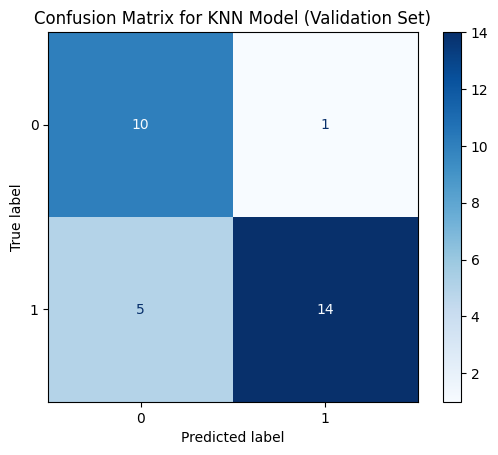

In [36]:
# Prepare validation data
X_validation = ha_validation.drop('output', axis=1)
y_validation = ha_validation['output']

# KNN evalutation -- so I carefully went through this code using prior knowledge and
# some online sources to ensure I was doing this correctly, then used the same format for the fallowiing 2
y_pred_proba_knn_val = best_knn_model.predict_proba(X_validation)[:, 1]
y_pred_knn_val = best_knn_model.predict(X_validation)

roc_auc_knn_val = roc_auc_score(y_validation, y_pred_proba_knn_val)
precision_knn_val = precision_score(y_validation, y_pred_knn_val)
recall_knn_val = recall_score(y_validation, y_pred_knn_val)

print(f"ROC AUC (Validation): {roc_auc_knn_val:.4f}")
print(f"Precision (Validation): {precision_knn_val:.4f}")
print(f"Recall (Validation): {recall_knn_val:.4f}")

cm_knn_val = confusion_matrix(y_validation, y_pred_knn_val)
disp_knn_val = ConfusionMatrixDisplay(confusion_matrix=cm_knn_val, display_labels=best_knn_model.classes_)
disp_knn_val.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN Model (Validation Set)")
plt.show()




ROC AUC (Validation): 0.9187
Precision (Validation): 0.9375
Recall (Validation): 0.7895


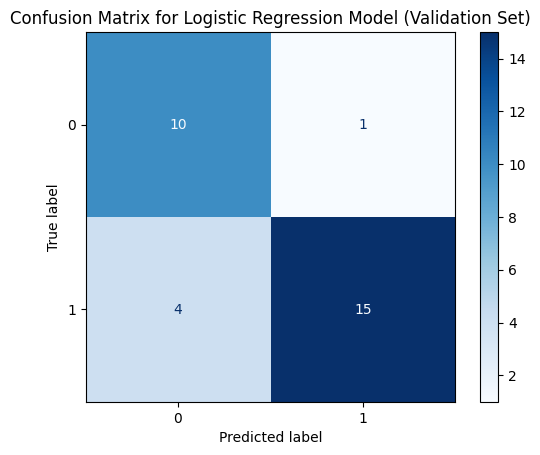

In [37]:
# Logistic -
y_pred_proba_logreg_val = best_logreg_model.predict_proba(X_validation)[:, 1]
y_pred_logreg_val = best_logreg_model.predict(X_validation)

roc_auc_logreg_val = roc_auc_score(y_validation, y_pred_proba_logreg_val)
precision_logreg_val = precision_score(y_validation, y_pred_logreg_val)
recall_logreg_val = recall_score(y_validation, y_pred_logreg_val)

print(f"ROC AUC (Validation): {roc_auc_logreg_val:.4f}")
print(f"Precision (Validation): {precision_logreg_val:.4f}")
print(f"Recall (Validation): {recall_logreg_val:.4f}")

cm_logreg_val = confusion_matrix(y_validation, y_pred_logreg_val)
disp_logreg_val = ConfusionMatrixDisplay(confusion_matrix=cm_logreg_val, display_labels=best_logreg_model.classes_)
disp_logreg_val.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression Model (Validation Set)")
plt.show()


ROC AUC (Validation): 0.8373
Precision (Validation): 0.8333
Recall (Validation): 0.5263


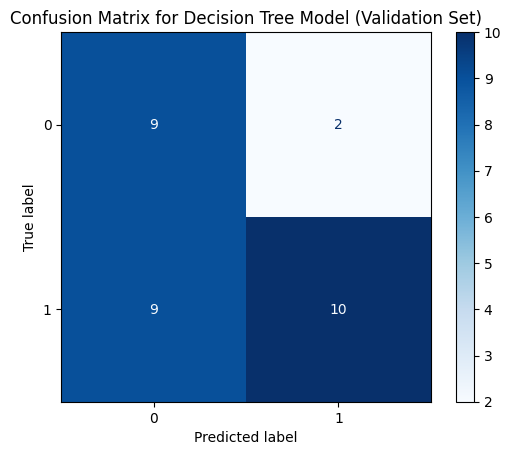

In [38]:

# Decision Tree model
y_pred_proba_dt_val = best_dt_model.predict_proba(X_validation)[:, 1]
y_pred_dt_val = best_dt_model.predict(X_validation)

roc_auc_dt_val = roc_auc_score(y_validation, y_pred_proba_dt_val)
precision_dt_val = precision_score(y_validation, y_pred_dt_val)
recall_dt_val = recall_score(y_validation, y_pred_dt_val)

print(f"ROC AUC (Validation): {roc_auc_dt_val:.4f}")
print(f"Precision (Validation): {precision_dt_val:.4f}")
print(f"Recall (Validation): {recall_dt_val:.4f}")

cm_dt_val = confusion_matrix(y_validation, y_pred_dt_val)
disp_dt_val = ConfusionMatrixDisplay(confusion_matrix=cm_dt_val, display_labels=best_dt_model.classes_)
disp_dt_val.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Decision Tree Model (Validation Set)")
plt.show()


In [40]:

# - Data to compere I just made a new list
print(" Compariing Validated to original ")
comparison_data = {
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree'],
    'CV ROC AUC': [np.mean(cv_results['test_roc_auc']), np.mean(grid_search_logreg.cv_results_['mean_test_score']), np.mean(grid_search_dt.cv_results_['mean_test_score'])],
    'Validation ROC AUC': [roc_auc_knn_val, roc_auc_logreg_val, roc_auc_dt_val],
    'CV Precision': [np.mean([x for x in cv_results['test_precision'] if not np.isnan(x)]), np.mean(results_df.loc['Logistic Regression']['Mean Precision (Positive Predictive Value)']), np.mean(results_df.loc['Decision Tree']['Mean Precision (Positive Predictive Value)'])],
    'Validation Precision': [precision_knn_val, precision_logreg_val, precision_dt_val],
    'CV Recall': [np.mean(cv_results['test_recall']), np.mean(results_df.loc['Logistic Regression']['Mean Recall (Sensitivity)']), np.mean(results_df.loc['Decision Tree']['Mean Recall (Sensitivity)'])],
    'Validation Recall': [recall_knn_val, recall_logreg_val, recall_dt_val]
}


# Data to compere I just made a new list
comparison_data = {
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree'],
    'CV ROC AUC': [
        results_df.loc['KNN']['Mean ROC AUC'],
        results_df.loc['Logistic Regression']['Mean ROC AUC'],
        results_df.loc['Decision Tree']['Mean ROC AUC']
    ],
    'Validation ROC AUC': [roc_auc_knn_val, roc_auc_logreg_val, roc_auc_dt_val],
    'CV Precision': [
        results_df.loc['KNN']['Mean Precision (Positive Predictive Value)'],
        results_df.loc['Logistic Regression']['Mean Precision (Positive Predictive Value)'],
        results_df.loc['Decision Tree']['Mean Precision (Positive Predictive Value)']
    ],
    'Validation Precision': [precision_knn_val, precision_logreg_val, precision_dt_val],
    'CV Recall': [
        results_df.loc['KNN']['Mean Recall (Sensitivity)'],
        results_df.loc['Logistic Regression']['Mean Recall (Sensitivity)'],
        results_df.loc['Decision Tree']['Mean Recall (Sensitivity)']
    ],
    'Validation Recall': [recall_knn_val, recall_logreg_val, recall_dt_val]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))

 Compariing Validated to original 
                 Model  CV ROC AUC  Validation ROC AUC  CV Precision  \
0                  KNN      0.8460              0.9354        0.7976   
1  Logistic Regression      0.8530              0.9187        0.7868   
2        Decision Tree      0.7732              0.8373        0.7958   

   Validation Precision  CV Recall  Validation Recall  
0                0.9333     0.7943             0.7368  
1                0.9375     0.8152             0.7895  
2                0.8333     0.7398             0.5263  


Again, used code then used the help of ai to organize this into a cleaner table

This actually did a fantastic job on this new data! The ROC AUC went up for all three which very high values which I am happy with, the Preicision went up for all three for each as well with the KNN and Logisitic Regression models specfically crushing it, then Recall did go down which was the one thing I wasnt great at, too many false negaitves, but overall a good job

The decision tree struggled the most, ESPECIALLT with recall, predicting many now at risk when they really were

Overall pretty pleased by these results and through lot's of tuning it seems like it did a good jo!

# **Part Five: Cohen’s Kappa**

Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [42]:
from sklearn.metrics import cohen_kappa_score
import pandas as pd

# --- Calculate Cohen's Kappa for KNN Model ---
y_pred_knn = best_knn_model.predict(X_test)
kappa_knn = cohen_kappa_score(y_test, y_pred_knn)
print(f"Cohen's Kappa for KNN Model: {kappa_knn:.4f}")

# --- Calculate Cohen's Kappa for Logistic Regression Model ---
y_pred_logreg = best_logreg_model.predict(X_test)
kappa_logreg = cohen_kappa_score(y_test, y_pred_logreg)
print(f"Cohen's Kappa for Logistic Regression Model: {kappa_logreg:.4f}")

# --- Calculate Cohen's Kappa for Decision Tree Model ---
y_pred_dt = best_dt_model.predict(X_test)
kappa_dt = cohen_kappa_score(y_test, y_pred_dt)
print(f"Cohen's Kappa for Decision Tree Model: {kappa_dt:.4f}")



Cohen's Kappa for KNN Model: 0.5078
Cohen's Kappa for Logistic Regression Model: 0.5657
Cohen's Kappa for Decision Tree Model: 0.4020


Reasons or scenario's that make use perfer to use this as a metric to model success :

Through research, it sounds like there are a few major reasons. Cohen's Kappa model measures how much better a model's predictions agree with true outcomes "beyond what you would expect" meaning it doesn't just reward correctness in an extremely predictable dataset's

So it seems like when there is class imbalence, like maybe more patients are "not at risk" a model that always predictors not at risk may seem accurate, but is not actually helpful. So Kappa helps correct for penalizing agreement that could just be happening randomly based on the split of data. As talked about, it adjusts for chance "agreement better", discounting lucky guesses that could of happened radnomly, giving a better picture of model reliability. So the values are lower, but in a lot of cases it maybe does paint a better picture of what's going on

My conclusion would not have chanegd tho since logistc regression is still doing the best with a score of 0.5657 which is the same as the highest ROC AUC value as well! I think this goes to show that although different approaches can change model selection, the best models still do consistenyl well across the board! It is very intresting to see what these different models care about, and how it changes scores.